In [46]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [47]:
# importing the requests library 
import requests 
import pandas as pd
import numpy as np
import time
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

from sklearn.model_selection import train_test_split, GridSearchCV

from IPython import display

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, BatchNormalization
from keras.layers import Bidirectional, AveragePooling1D, Flatten, TimeDistributed
from keras.layers import Lambda
from keras.optimizers import Adam

from sklearn import metrics
from scipy import stats
from keras.utils import plot_model

tf.test.gpu_device_name()

''

In [48]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18318574327958675900]

In [49]:
datos = pd.read_csv("CurvasOferta.csv",header=None,index_col=0,verbose=False)

In [50]:
datos.shape

(43824, 500)

In [51]:
datos

,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500
0,,,,,,,,,,,,,,,,,,,,,
1,0,26.00,26.0,26.00,26.00,26.00,26.00,26.00,26.00,26.00,...,66.22,66.24,66.24,66.24,66.24,66.24,66.24,66.24,66.24,66.24
2,0,26.00,26.0,26.00,26.00,26.00,26.00,26.00,26.00,26.00,...,66.27,66.28,66.28,66.28,66.28,66.28,66.28,66.28,66.28,66.28
3,0,25.00,25.0,41.15,41.15,41.15,41.15,41.15,41.15,41.15,...,73.76,75.33,75.33,75.33,75.33,75.33,75.33,75.33,75.33,75.33
4,0,0.01,5.0,5.00,5.00,5.00,25.00,25.00,25.00,25.00,...,73.49,73.49,73.49,73.49,73.49,73.49,73.50,73.50,73.50,73.50
5,0,25.00,25.0,25.00,25.00,25.00,25.00,25.00,25.00,25.00,...,67.03,67.03,67.03,67.03,67.03,67.03,67.03,67.03,67.03,67.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43820,0,60.00,60.0,65.00,65.00,65.00,65.00,65.00,67.35,67.35,...,72.35,72.35,72.35,72.35,72.35,72.35,72.35,72.35,72.35,72.35
43821,0,60.00,60.0,60.00,64.47,64.47,64.47,64.47,64.47,64.47,...,72.19,72.19,72.19,72.19,72.19,72.19,72.19,72.19,72.19,72.19
43822,0,45.00,45.0,45.00,46.00,46.00,46.00,46.00,50.00,50.00,...,70.99,70.99,70.99,70.99,70.99,70.99,70.99,70.99,70.99,70.99


In [52]:
q = np.linspace(start = 0, stop = 2000, num=500)

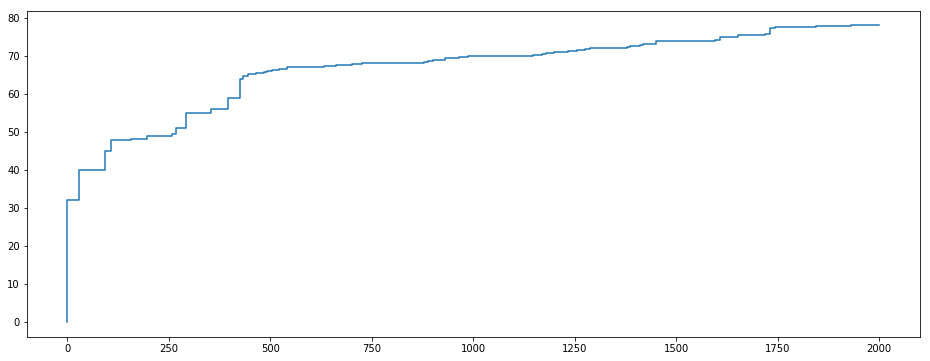

In [53]:
plt.figure(figsize=(16,6))
plt.step(q, datos.iloc[200])
plt.show()

In [54]:
a = np.array(datos)

In [55]:
data_rs = np.reshape(a, 43824*500)

In [56]:
data_rs.shape

(21912000,)

In [57]:
k = 5

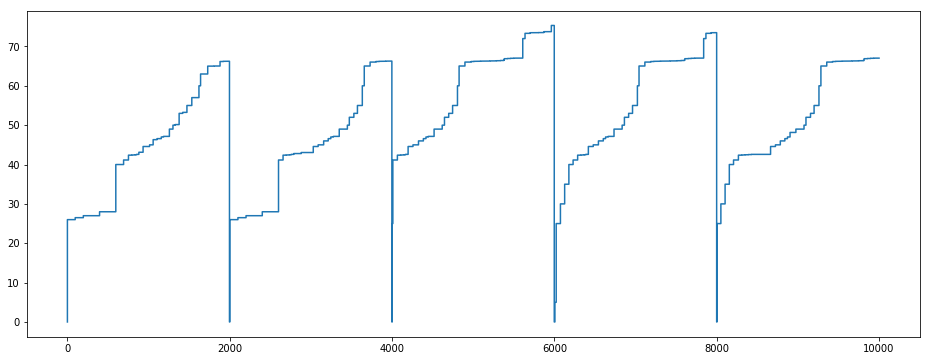

In [58]:
plt.figure(figsize=(16,6))
plt.step(np.linspace(start = 0, stop = k*2000, num=k*500), data_rs[0:k*500])
plt.show()

In [59]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    range = np.arange(start = 0, stop = len(sequence), step = n_steps_out)
    for i in range:
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        seq_y = sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [60]:
past_hours = 12
forecast_hours = 1
n_steps_in = past_hours*500
n_steps_out = forecast_hours*500
# split into samples
X, y = split_sequence(data_rs, n_steps_in, n_steps_out)

In [61]:
print("Shape X --> " + str(X.shape))
print("Shape y --> " + str(y.shape))

Shape X --> (43812, 6000)
Shape y --> (43812, 500)


In [62]:
test_size = 365*24
train_size = len(X) - test_size
X_train, y_train = X[0:train_size], y[0:train_size]
X_test, y_test = X[train_size:len(X)], y[train_size:len(X)]

In [63]:
print("Shape X_train --> " + str(X_train.shape))
print("Shape y_train --> " + str(y_train.shape))
print("Shape X_test  --> " + str(X_test.shape))
print("Shape y_test  --> " + str(y_test.shape))

Shape X_train --> (35052, 6000)
Shape y_train --> (35052, 500)
Shape X_test  --> (8760, 6000)
Shape y_test  --> (8760, 500)


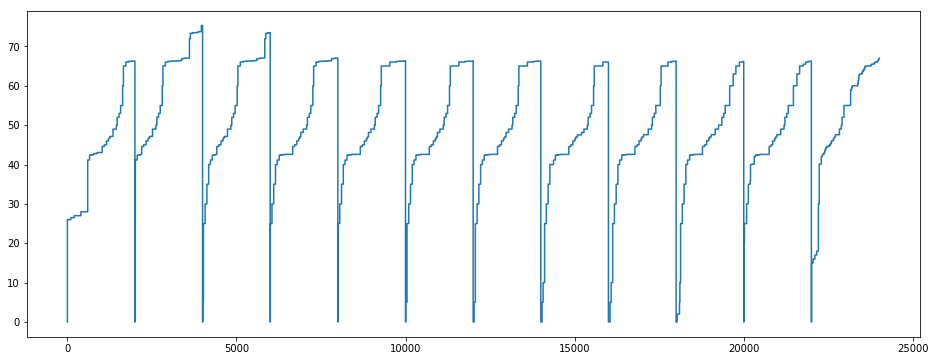

In [64]:
plt.figure(figsize=(16,6))
plt.step(np.linspace(start = 0, stop = past_hours*2000, num=past_hours*500), X_train[1])
plt.show()

In [65]:
n_features = 1 # Hay q definir el tensor así
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [66]:
print("Shape X_train --> " + str(X_train.shape))
print("Shape y_train --> " + str(y_train.shape))
print("Shape X_test  --> " + str(X_test.shape))
print("Shape y_test  --> " + str(y_test.shape))

Shape X_train --> (35052, 6000, 1)
Shape y_train --> (35052, 500)
Shape X_test  --> (8760, 6000, 1)
Shape y_test  --> (8760, 500)


In [67]:
from keras import backend as K 
def euc_dist_keras(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True))

In [68]:
model = Sequential()
model.add(Conv1D(filters = 100, kernel_size = 100, strides=4, padding='valid', activation = "linear",
                 input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Conv1D(filters = 50, kernel_size = 50, strides=4, padding='valid'))
model.add(Conv1D(filters = 25, kernel_size = 25, strides=4, padding='valid'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Dense(50))
model.add(Flatten())
model.add(Dense(n_steps_out))
model.add(Lambda(lambda x: tf.sort(x)))

model.compile(loss = euc_dist_keras,
              optimizer = Adam(0.001))

In [69]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 1476, 100)         10100     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 357, 50)           250050    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 84, 25)            31275     
_________________________________________________________________
dense_3 (Dense)              (None, 84, 50)            1300      
_________________________________________________________________
flatten_2 (Flatten)          (None, 4200)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               2100500   
_________________________________________________________________
lambda_2 (Lambda)            (None, None)             

In [ ]:
history = model.fit(X_train, y_train,
                    epochs = 5,
                    batch_size = 50,
                    #validation_split = 0.2,
                    validation_data = (X_test,y_test),
                    verbose = 1,
                    shuffle = True)

Train on 35052 samples, validate on 8760 samples
Epoch 1/5
35052/35052 [==============================] - 1256s 36ms/step - loss: 148.0525 - val_loss: 144.7366
Epoch 2/5
35052/35052 [==============================] - 1301s 37ms/step - loss: 91.0924 - val_loss: 127.6968
Epoch 3/5
35052/35052 [==============================] - 1289s 37ms/step - loss: 88.8132 - val_loss: 158.2681
Epoch 4/5
35052/35052 [==============================] - 1260s 36ms/step - loss: 87.7554 - val_loss: 111.5974
Epoch 5/5
15200/35052 [============>.................] - ETA: 11:27 - loss: 86.9464

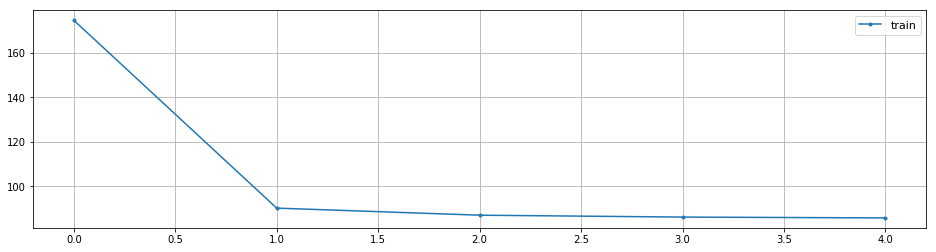

In [28]:
plt.figure(figsize=(16,4))
plt.plot(history.history['loss'], label='train', marker='.')
#plt.plot(history.history['val_loss'], label='validation', marker='.')
plt.grid(True)
plt.legend(fontsize=11);

In [29]:
#y_pred = tf.sort(model.predict(X_test, verbose=1))
y_pred = model.predict(X_test, verbose=1)

8760/8760 [==============================] - 139s 16ms/step


In [30]:
from scipy.spatial import distance
errores = np.empty([len(y_test)]) 
for i in range(0,len(y_test)):
    errores[i] = distance.euclidean(u = y_pred[i], v = y_test[i])

In [41]:
pd.DataFrame(errores).describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
0,8760.0,115.86,1349.23,9.99,41.22,59.09,90.38,112266.08


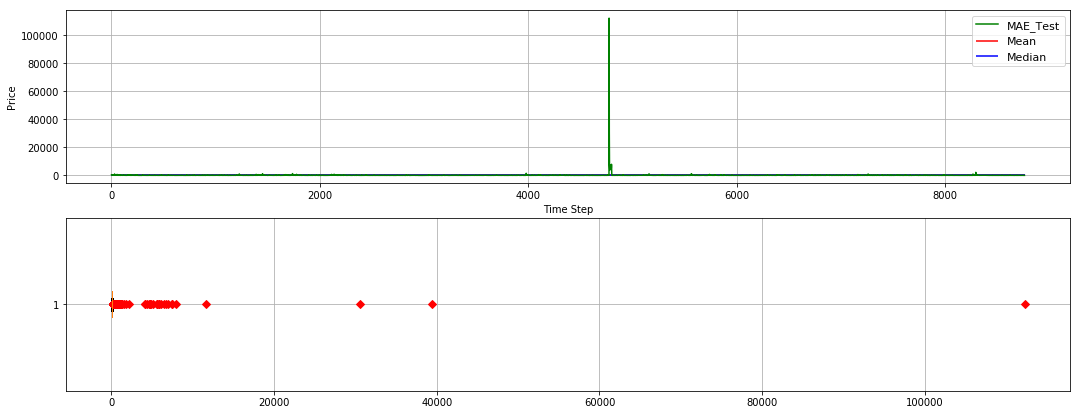

In [32]:
plt.figure(figsize=(18, 7))
plt.subplot(211)
plt.plot(np.arange(0, len(errores)), errores, 'g', label="MAE_Test")
plt.ylabel('Price')
plt.xlabel('Time Step')
plt.hlines(np.mean(errores),xmax=len(errores),xmin=0,colors="red",label="Mean")
plt.hlines(np.median(errores),xmax=len(errores),xmin=0,colors="blue",label="Median")
plt.grid(True)
plt.legend(fontsize=11)

plt.subplot(212)
plt.boxplot(errores, 0, 'rD', vert = False, patch_artist=True,)
plt.grid(True)
plt.show();

In [42]:
best = np.argmin(errores)
worse = np.argmax(errores)

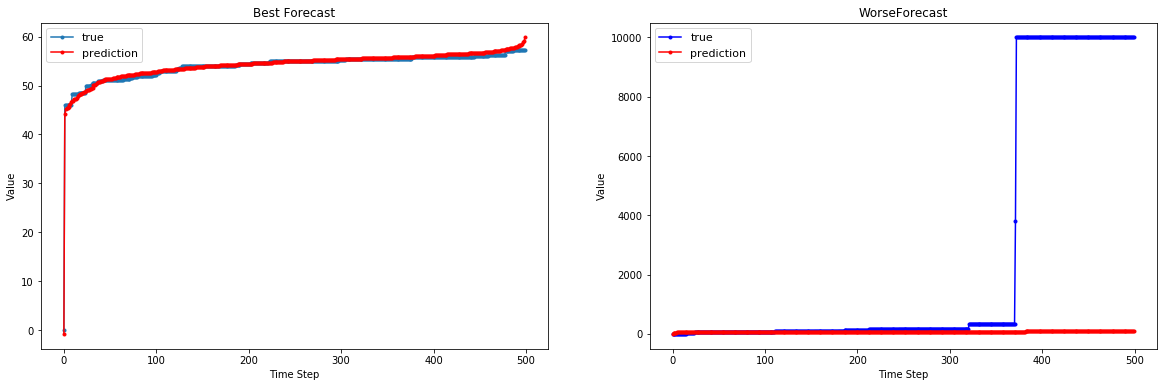

In [43]:
plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.title("Best Forecast")
plt.plot(y_test[best], marker='.', label="true")
plt.plot(y_pred[best], 'r', marker = ".", label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
#plt.ylim(top = maximo, bottom = minimo)
plt.legend(fontsize=11)

plt.subplot(122)
plt.title("WorseForecast")
plt.plot(y_test[worse], color = "blue", marker='.', label="true")
plt.plot(y_pred[worse], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend(fontsize=11)
#plt.ylim(top = maximo, bottom = minimo)
plt.show();

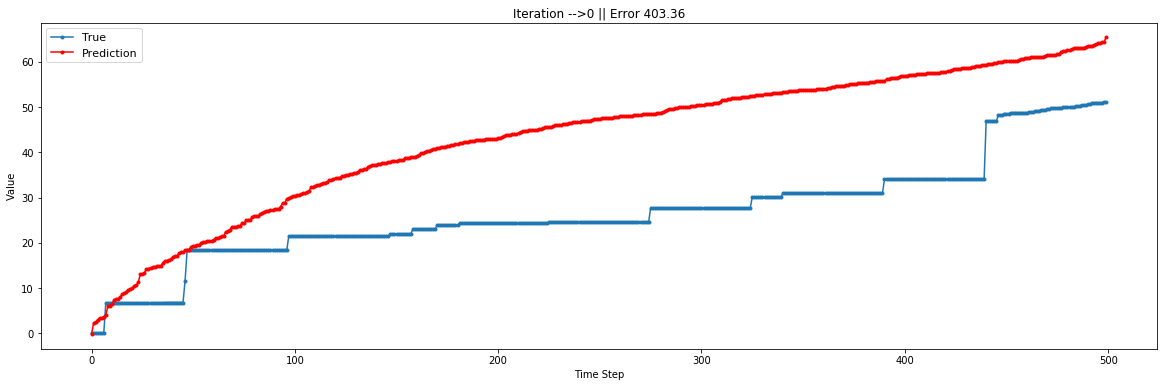

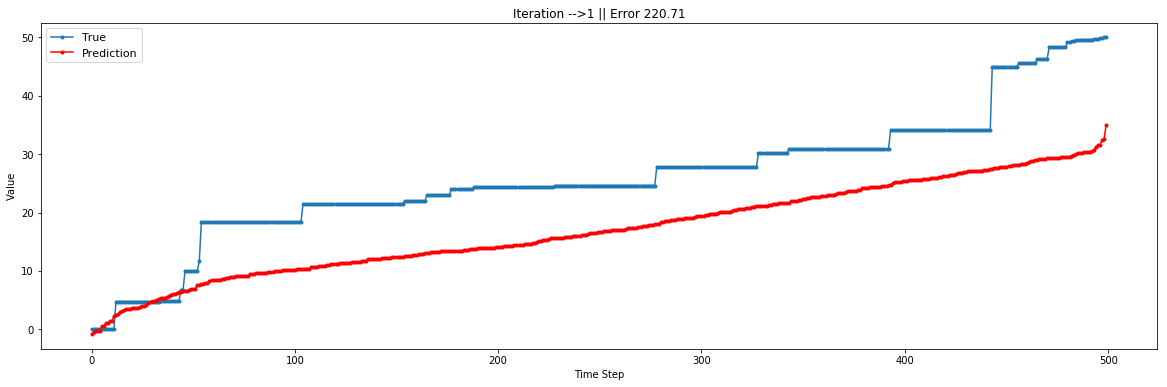

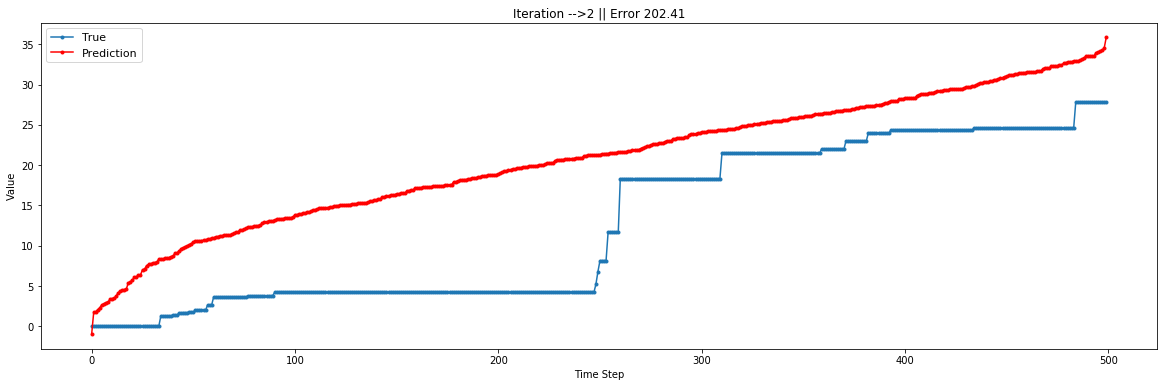

In [44]:
n = len(errores)
n = 3
for i in range(0,n):
  plt.figure(figsize=(20, 6))
  plt.title("Iteration -->" + str(i) + " || Error " + str(round(errores[i],2)))
  plt.plot(y_test[i], marker='.', label="True")
  plt.plot(y_pred[i], 'r', marker = ".", label="Prediction")
  plt.ylabel('Value')
  plt.xlabel('Time Step')
  plt.legend(fontsize=11)
  #plt.ylim(top = 120, bottom = 0)
  #plt.show()
  plt.plot()
  plt.savefig("value" + str(i) + ".png")
  display.display(plt.gcf())
  display.clear_output(wait=True)
  time.sleep(2)

In [45]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [93]:
from keras.models import model_from_json
# later...
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [94]:
y_pred = tf.sort(model.predict(X_test, verbose=1))
#y_pred = model.predict(X_test, verbose=1)

10950/10950 [==============================] - 90s 8ms/step


In [ ]:
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

#### TRASH

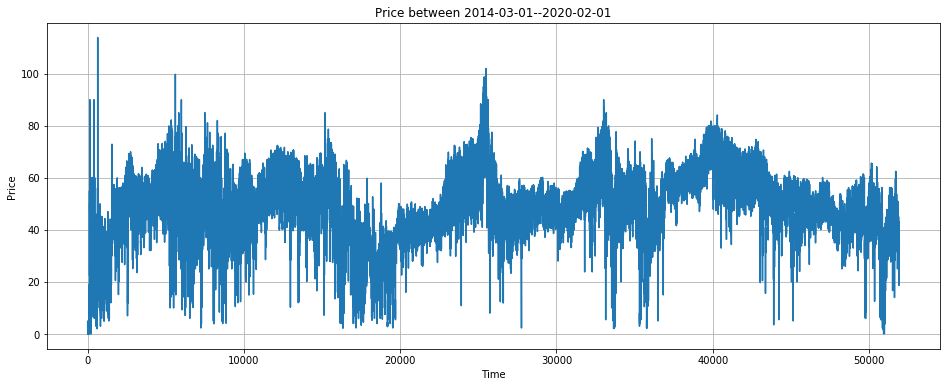

In [17]:
plt.figure(figsize=(16,6))
plt.title('Price between ' + start_day + "--" + end_day)
plt.xlabel('Time'); plt.ylabel('Price')
plt.grid(True)
plt.plot(df["value"]);

In [18]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    range = np.arange(start = 0, stop = len(sequence), step = n_steps_out)
    for i in range:
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        seq_y = sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [19]:
past_days = 7
n_steps_in = past_days*24
n_steps_out = 24
# split into samples
X, y = split_sequence(df["value"], n_steps_in, n_steps_out)

In [20]:
print("Shape X --> " + str(X.shape))
print("Shape y --> " + str(y.shape))

Shape X --> (2157, 168)
Shape y --> (2157, 24)


In [22]:
train_size = int(len(X) - 365)
test_size = len(X) - train_size
X_train, y_train = X[0:train_size], y[0:train_size]
X_test, y_test = X[train_size:len(X)], y[train_size:len(X)]

In [23]:
print("Shape X_train --> " + str(X_train.shape))
print("Shape y_train --> " + str(y_train.shape))
print("Shape X_test  --> " + str(X_test.shape))
print("Shape y_test  --> " + str(y_test.shape))

Shape X_train --> (1792, 168)
Shape y_train --> (1792, 24)
Shape X_test  --> (365, 168)
Shape y_test  --> (365, 24)


In [24]:
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [25]:
print("Shape X_train --> " + str(X_train.shape))
print("Shape y_train --> " + str(y_train.shape))
print("Shape X_test  --> " + str(X_test.shape))
print("Shape y_test  --> " + str(y_test.shape))

Shape X_train --> (1792, 168, 1)
Shape y_train --> (1792, 24)
Shape X_test  --> (365, 168, 1)
Shape y_test  --> (365, 24)


In [26]:
from keras import backend as K 
def euc_dist_keras(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True))

In [127]:
model = Sequential()
model.add(Conv1D(filters = 32, kernel_size=6, strides=2, padding='valid', activation = "linear",
                 input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Conv1D(filters = 16, kernel_size=2, strides=2, activation='linear'))
model.add(MaxPooling1D(pool_size=3))
#model.add(LSTM(units = 128, activation="linear",return_sequences=False))
model.add(Flatten())
model.add(Dense(units = 100, activation='tanh'))
model.add(Dense(units = 1000, activation='linear'))
model.add(Dense(n_steps_out))
model.compile(loss = euc_dist_keras,
              optimizer = Adam(0.001))

ValueError: Attempt to convert a value (<keras.layers.core.Dense object at 0x000001247E880710>) with an unsupported type (<class 'keras.layers.core.Dense'>) to a Tensor.

In [102]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 82, 32)            224       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 41, 16)            1040      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 13, 16)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 208)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               20900     
_________________________________________________________________
dense_7 (Dense)              (None, 1000)              101000    
_________________________________________________________________
dense_8 (Dense)              (None, 24)               

In [103]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=20,
                    #validation_split=0.1,
                    verbose=1,
                    shuffle=False)

Epoch 1/10
1792/1792 [==============================] - 2s 911us/step - loss: 87.9347
Epoch 2/10
1792/1792 [==============================] - 1s 746us/step - loss: 65.1598
Epoch 3/10
1792/1792 [==============================] - 1s 723us/step - loss: 63.3021
Epoch 4/10
1792/1792 [==============================] - 1s 703us/step - loss: 65.6223
Epoch 5/10
1792/1792 [==============================] - 1s 728us/step - loss: 63.5186
Epoch 6/10
1792/1792 [==============================] - 1s 734us/step - loss: 66.7092
Epoch 7/10
1792/1792 [==============================] - 1s 696us/step - loss: 63.5156
Epoch 8/10
1792/1792 [==============================] - 1s 687us/step - loss: 63.0514
Epoch 9/10
1792/1792 [==============================] - 1s 716us/step - loss: 61.7316
Epoch 10/10
1792/1792 [==============================] - 1s 683us/step - loss: 62.8984


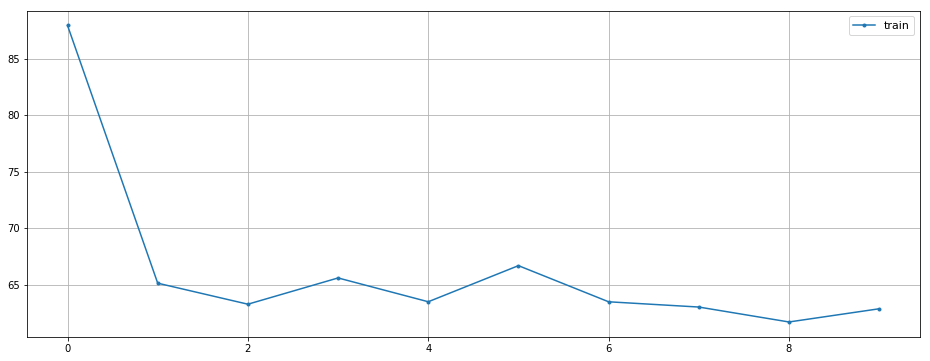

In [104]:
plt.figure(figsize=(16,6))
plt.plot(history.history['loss'], label='train', marker='.')
#plt.plot(history.history['val_loss'], label='validation', marker='.')
plt.grid(True)
plt.legend(fontsize=11);

In [128]:
y_pred = model.predict(X_test, verbose=1)

13821/13821 [==============================] - 5s 390us/step


In [129]:
errores = np.empty([len(y_test)]) 
for i in range(0,len(y_test)):
    errores[i] = distance.euclidean(u = y_pred[i], v = y_test[i])

ValueError: operands could not be broadcast together with shapes (1000,) (500,) 

In [107]:
stats.describe(errores)

DescribeResult(nobs=365, minmax=(39.47896287342495, 327.749916716592), mean=113.57487679314688, variance=1509.7017018031684, skewness=1.3989865722198953, kurtosis=4.657817904882478)

In [128]:
c1 = np.array([0,2,100,2,200,4])
c2 = np.array([0,3,300,3,400,4,500,5])

In [132]:
def split(ci):
    par = np.arange(0,len(ci),2)
    impar = np.arange(1,len(ci),2) 
    q = ci[par]
    p = ci[impar]
    return q,p

In [133]:
q1, p1 = split(c1)
q2, p2 = split(c2)

In [141]:
print(q1)
print(p1)
print(q2)
print(p2)

[  0 100 200]
[2 2 4]
[  0 300 400 500]
[3 3 4 5]


In [137]:
q = np.unique(np.concatenate([q1,q2]))
print(q)

[  0 100 200 300 400 500]


In [185]:
def reshape_offers(qi,pi):
    p = np.zeros([len(q)])
    c = 0
    for i in range(0,len(p)):
        if q[i] in qi:
            p[i] = pi[c]
            c = c + 1
        if (q[i] not in qi and c > len(qi)):    
            p[i] = p[i-1]    
    return p    

In [186]:
reshape_offers(q1,p1)

array([2., 2., 4., 0., 0., 0.])

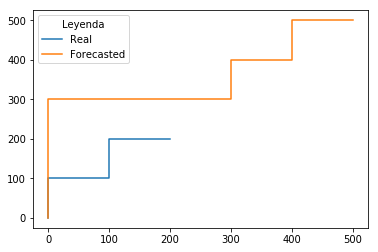

In [97]:
plt.step(q1, p1, label = "Real", where = "pre")
plt.step(q2, p2, label = "Forecasted", where = "pre")
plt.legend(title='Leyenda')
plt.show()

In [96]:
np.concatenate([q1,q2]).

array([  0, 100, 200,   0, 300, 400, 500])

In [92]:
qi = 

array([  0, 100, 200])

In [82]:
import matplotlib.pyplot as plt

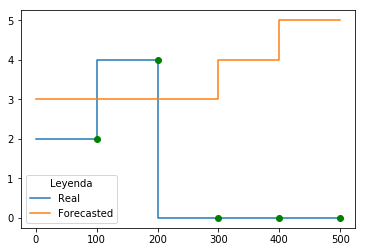

In [83]:
plt.step(qi, p1, label = "Real", where = "pre")
plt.plot(qi_, p1_, 'go')
plt.step(qi, p2, label = "Forecasted", where = "pre")
plt.legend(title='Leyenda')
plt.show()

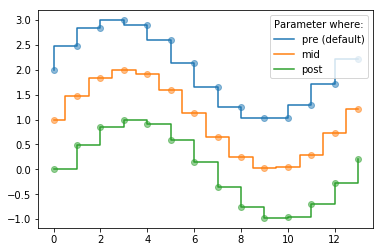

In [57]:
x = np.arange(14)
y = np.sin(x / 2)

plt.step(x, y + 2, label='pre (default)')
plt.plot(x, y + 2, 'C0o', alpha=0.5)

plt.step(x, y + 1, where='mid', label='mid')
plt.plot(x, y + 1, 'C1o', alpha=0.5)

plt.step(x, y, where='post', label='post')
plt.plot(x, y, 'C2o', alpha=0.5)

plt.legend(title='Parameter where:')
plt.show()

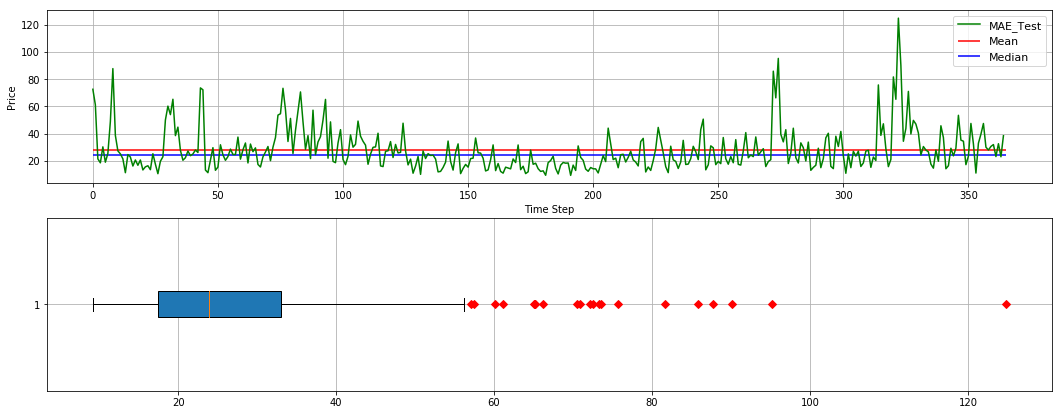

In [43]:
plt.figure(figsize=(18, 7))
plt.subplot(211)
plt.plot(np.arange(0, len(errores)), errores, 'g', label="MAE_Test")
plt.ylabel('Price')
plt.xlabel('Time Step')
plt.hlines(np.mean(errores),xmax=len(errores),xmin=0,colors="red",label="Mean")
plt.hlines(np.median(errores),xmax=len(errores),xmin=0,colors="blue",label="Median")
plt.grid(True)
plt.legend(fontsize=11)

plt.subplot(212)
plt.boxplot(errores, 0, 'rD', vert = False, patch_artist=True,)
plt.grid(True)
plt.show();

In [44]:
best = np.argmin(errores)
worse = np.argmax(errores)

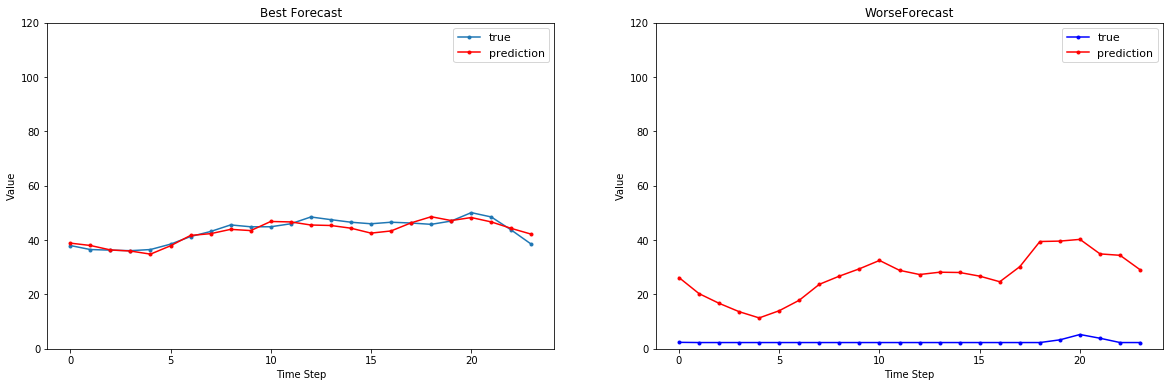

In [45]:
best = np.argmin(errores)
worse = np.argmax(errores)

plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.title("Best Forecast")
plt.plot(y_test[best], marker='.', label="true")
plt.plot(y_pred[best], 'r', marker = ".", label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.ylim(top = 120, bottom = 0)
plt.legend(fontsize=11)

plt.subplot(122)
plt.title("WorseForecast")
plt.plot(y_test[worse], color = "blue", marker='.', label="true")
plt.plot(y_pred[worse], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend(fontsize=11)
plt.ylim(top = 120, bottom = 0)
plt.show();

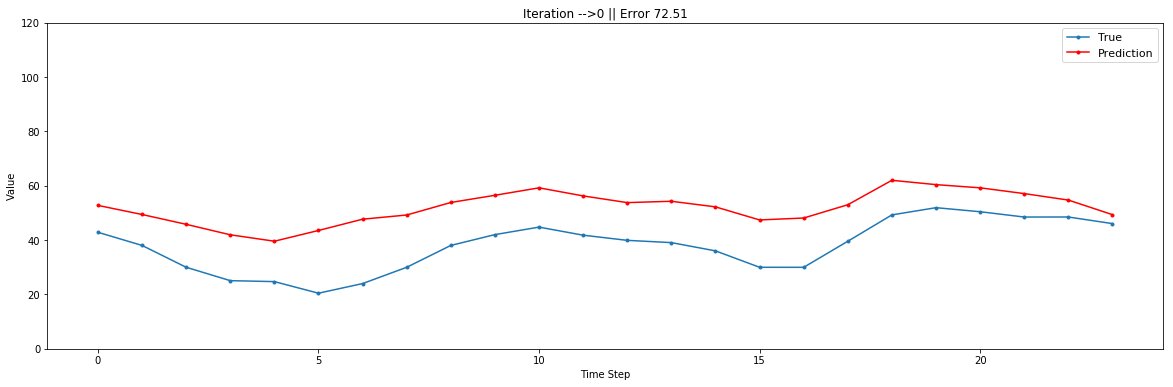

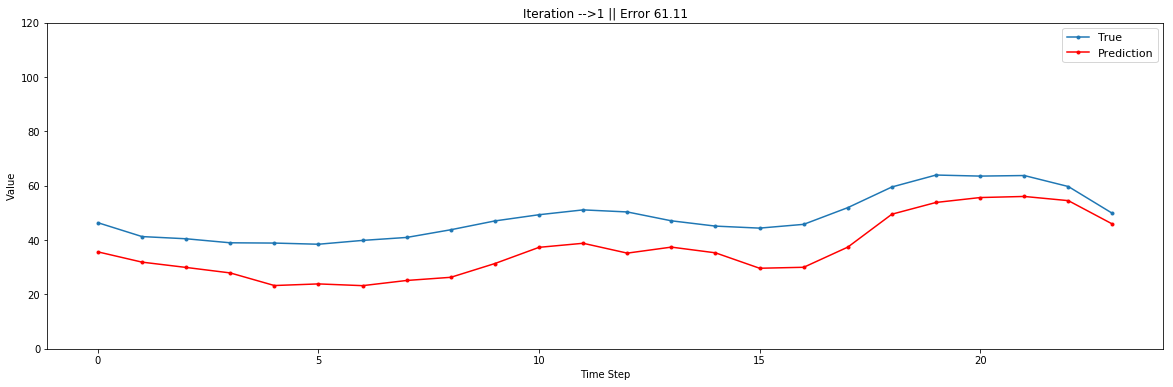

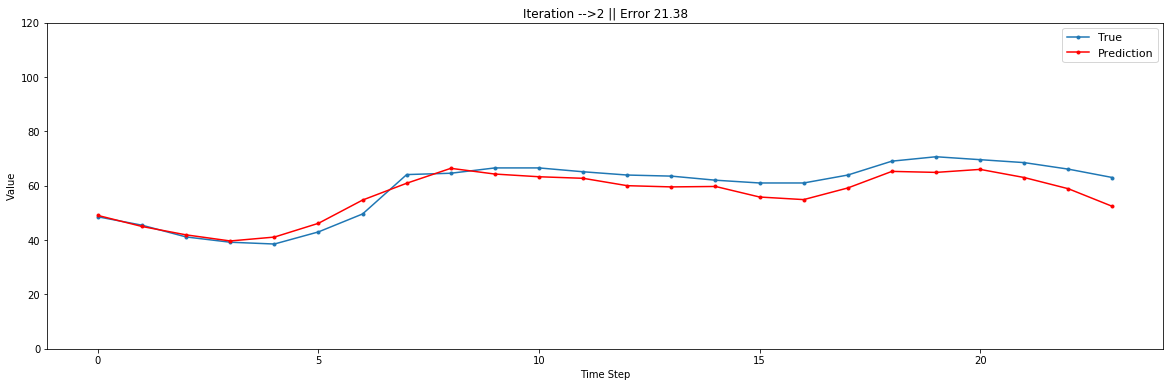

In [52]:
n = len(errores)
n = 3
for i in range(0,n):
  plt.figure(figsize=(20, 6))
  plt.title("Iteration -->" + str(i) + " || Error " + str(round(errores[i],2)))
  plt.plot(y_test[i], marker='.', label="True")
  plt.plot(y_pred[i], 'r', marker = ".", label="Prediction")
  plt.ylabel('Value')
  plt.xlabel('Time Step')
  plt.legend(fontsize=11)
  plt.ylim(top = 120, bottom = 0)
  #plt.show()
  plt.plot()
  plt.savefig("value" + str(i) + ".png")
  display.display(plt.gcf())
  display.clear_output(wait=True)
  time.sleep(2)